In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Professional Formatting
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (14, 7)

def get_performance_table(strat_returns, bh_returns):
    def calc_stats(res):
        cum_ret = (1 + res).prod() - 1
        ann_ret = (1 + cum_ret)**(365 / len(res)) - 1
        vol = res.std() * np.sqrt(365)
        sharpe = (res.mean() / res.std()) * np.sqrt(365)
        # Drawdown
        equity = (1 + res).cumprod()
        max_dd = (equity / equity.cummax() - 1).min()
        calmar = ann_ret / abs(max_dd)
        return [f"{ann_ret:.2%}", f"{vol:.2%}", round(sharpe, 3), f"{max_dd:.2%}", round(calmar, 3)]

    stats_labels = ['Ann. Return', 'Ann. Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio']
    df_perf = pd.DataFrame({
        "Strategy (Mining+OU)": calc_stats(strat_returns),
        "BTC Buy & Hold": calc_stats(bh_returns)
    }, index=stats_labels)
    return df_perf

In [28]:
# Path to your file
path = "/Users/samgeng14/PycharmProjects/LunaExchange/Market Data/Crypto Data/cleaned_crypto_data.csv"
df = pd.read_csv(path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

# Extract key columns based on your CSV screenshot
btc = pd.DataFrame({
    'price': df['BTC-USD_close'],
    'cost': df['COST_TO_MINE'],
    'reward': df['BTC_REWARD']
})

# Filter for the 'Active Period' where data is dynamic (avoiding the flat 2008-2014 period)
btc = btc.loc['2016-01-01':].copy()
btc['returns'] = btc['price'].pct_change().fillna(0)

print(f"Backtest range: {btc.index[0]} to {btc.index[-1]}")

Backtest range: 2016-01-01 00:00:00 to 2026-02-10 00:00:00


In [29]:
# 1. Valuation Spread (Price / Cost)
# A spread of 1.0 means price = mining cost. < 1.0 is "undervalued".
btc['valuation_ratio'] = btc['price'] / btc['cost']

# 2. OU Process Tactical Signal (90-day rolling Z-Score)
def rolling_zscore(s, window=90):
    return (s - s.rolling(window).mean()) / s.rolling(window).std()

# We apply the OU Z-score to log-prices to detrend it
btc['ou_zscore'] = rolling_zscore(np.log(btc['price']), 90)

# 3. Trend Regime Filter
btc['ma_200'] = btc['price'].rolling(200).mean()
btc['regime_trend'] = np.where(btc['price'] > btc['ma_200'], 1, 0) # 1 for Bull, 0 for Bear/Sideways

In [30]:
# Default Position: Cash (0)
btc['signal'] = 0.0

# CONDITION 1: Mining Floor (Long if price is within 10% of cost or lower)
btc.loc[btc['valuation_ratio'] < 1.1, 'signal'] = 1.0

# CONDITION 2: Tactical Mean Reversion (If NOT trending, buy deep OU oversold)
btc.loc[(btc['regime_trend'] == 0) & (btc['ou_zscore'] < -1.5), 'signal'] = 1.0

# CONDITION 3: Momentum Overlay (If trending, stay long regardless of OU)
btc.loc[(btc['regime_trend'] == 1) & (btc['ou_zscore'] > -1.0), 'signal'] = 1.0

# CONDITION 4: De-risk (Go flat if OU is extremely overheated AND price is 2x cost)
btc.loc[(btc['ou_zscore'] > 2.5) & (btc['valuation_ratio'] > 2.0), 'signal'] = 0.0

# Final Signal - 1 day lag
btc['strat_pos'] = btc['signal'].shift(1).fillna(0)
btc['strat_returns'] = btc['strat_pos'] * btc['returns']

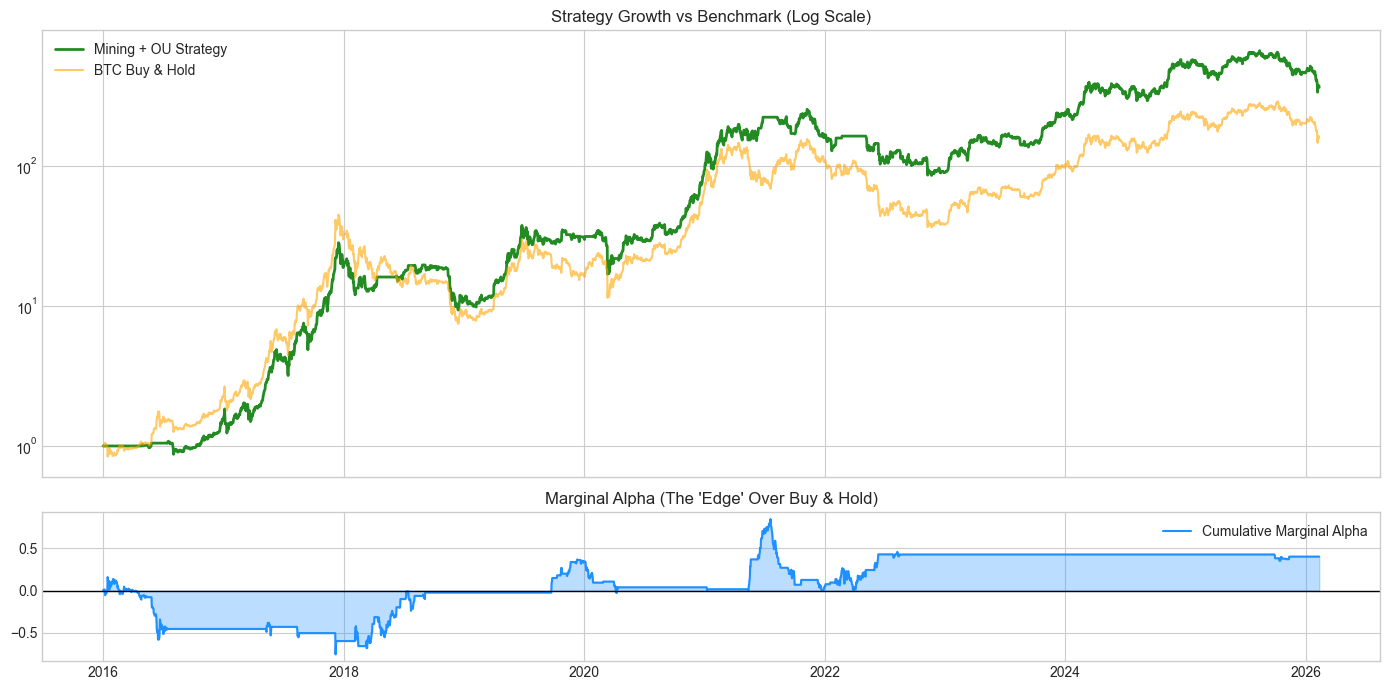

In [34]:
# Equity Curves
btc['strategy_equity'] = (1 + btc['strat_returns']).cumprod()
btc['bh_equity'] = (1 + btc['returns']).cumprod()

# Marginal Alpha Calculation
# (Strategy Return - Benchmark Return)
btc['marginal_alpha'] = (btc['strat_returns'] - btc['returns']).cumsum()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Top: Equity Curve Comparison
ax1.plot(btc['strategy_equity'], label='Mining + OU Strategy', color='forestgreen', lw=2)
ax1.plot(btc['bh_equity'], label='BTC Buy & Hold', color='orange', alpha=0.6)
ax1.set_yscale('log')
ax1.set_title("Strategy Growth vs Benchmark (Log Scale)")
ax1.legend()

# Bottom: Marginal Alpha Contribution
ax2.fill_between(btc.index, 0, btc['marginal_alpha'], color='dodgerblue', alpha=0.3)
ax2.plot(btc['marginal_alpha'], color='dodgerblue', label='Cumulative Marginal Alpha')
ax2.axhline(0, color='black', lw=1)
ax2.set_title("Marginal Alpha (The 'Edge' Over Buy & Hold)")
ax2.legend()

plt.tight_layout()
plt.show()

In [35]:
print("Institutional Performance Report: BTC Mining & OU Tactical Combo")
print("-" * 65)
perf_table = get_performance_table(btc['strat_returns'], btc['returns'])
display(perf_table)

# Final Alpha Print
total_alpha = btc['marginal_alpha'].iloc[-1]
print(f"\nFinal Cumulative Alpha: {total_alpha:.2%}")

Institutional Performance Report: BTC Mining & OU Tactical Combo
-----------------------------------------------------------------


,Strategy (Mining+OU),BTC Buy & Hold
Ann. Return,79.15%,65.01%
Ann. Volatility,60.30%,66.99%
Sharpe Ratio,1.272,1.085
Max Drawdown,-66.95%,-83.40%
Calmar Ratio,1.182,0.78



Final Cumulative Alpha: 40.26%
